# Assignment 2 - Inverse Problems

Author: Emilie Berg (ncb427)

In [1]:
# import relevant libraries
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(8)  # set seed for random number generator

In [2]:
data = np.genfromtxt("dataM.txt")  # load data
x_d = (data[:,0] + 50) * 10e-3  # position data in m
d_vector = data[:,1] * 10e-9  # magnetic field data in T

# I define relevant constants for later use
N_bands = 200  # the number of bands
w0 = 4 * 10e-3  # the mean stripe width in m
mu_mag = 0  # the mean surface dipole magnetization of a stripe in Am^-1
sigma_mag = 0.025  # the standard deviation of the surface dipole magnetization of a stripe Am^-1
h = 2 * 10e-3  # the height above the plate that the measurements were taken in m
mu_data = 0  # the mean value of the data in T
sigma_data = 25 * 10e-9  # the uncertainty on a data-point in T
mu0 = 4*np.pi * 10e-7  # the permeability of free space in N/A^2

x_total = 100 * 10e-3  # the width of the entire plate in m
dx = x_total/200  # the width of a single band in m
x_m = np.arange(dx/2, x_total+dx/2, dx)  # position of each band in m (taken as the middle of each band)

N_samples = 10000  # the number of samples from the metropolis algorithm


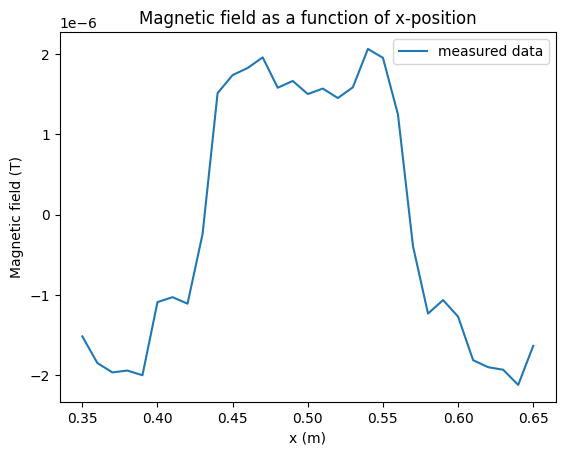

In [3]:
# I start by plotting the data
plt.plot(x_d, d_vector, label="measured data")
plt.xlabel("x (m)")
plt.ylabel("Magnetic field (T)")
plt.title("Magnetic field as a function of x-position")
plt.legend()

### Question 1

When the forward relation between model and data is given by an exact expression, the posterior probability distribution is given by

$$\sigma_m(m) = k \rho(m, f(m)) \frac{\sqrt{\det(g_m + F^T g_d F)}}{\sqrt{\det(g_m)} \sqrt{\det(g_d)}}$$

at $d = F(m)$ (see equation 55). When the data are "a priori" independent of the model, we have $\rho(m, f(m)) = \rho(m) \rho(d)$, and hence the above reduces to

$$\sigma_m(m) = k \rho_m(m) \frac{\rho_d(d)}{\sqrt{\det(g_d)}} \frac{\sqrt{\det(g_m + F^T g_d F)}}{\sqrt{\det(g_m)}}$$

at $d = F(m)$. But since the problem is actually linear, this reduces further to

$$\sigma_m(m) = k \rho_m(m) \frac{\rho_d(F(m))}{\mu_d(F(m))} = k \rho_m(m) \frac{L(m)}{\mu_d(F(m))},$$

where I have used the fact that $\mu_d(d) = \sqrt{\det(g_d)}$ and defined the likelihood as the prior probability distribution of the data given the forward relation $L(m) = \rho_d(F(m))$. In the problem set it is specified that the uncertainties of the measured data follows a gaussian distribution, and hence $\rho_d(d)$ is gaussian

$$\rho_d(d) = k \exp(-\frac{1}{2} (d_{obs} - d)^T C_D^{-1} (d_{obs} - d)).$$

Evaluating this at $d = F(m) = Gm$ gives me the likelihood

$$L(m) = k \exp(-\frac{1}{2} (d_{obs} - Gm)^T C_D^{-1} (d_{obs} - Gm)).$$

And that is why the likelihood is given by this expression.

### Question 2

I start by building an algorithm that samples the prior $\rho(m)$. To do this I have followed the describtion given in the problem set.

In [4]:
def sample_prior(m, N_bands=N_bands):
    """This function samples the prior rho(m). Given an array with magnetization of each band m, the function computes a perturbed array according to the prior rho(m)."""

    m = np.copy(m)  # make a copy of the current magnetizations

    boundaries = np.where(m[:-1] != m[1:])[0] + 1  # locate the boundaries of each stripe
    stripes = np.split(m, boundaries)  # make a list of arrays where each array consists of the bands in a given stripe

    decision = np.random.uniform()  # make a random decision between a pure magnetization perturbation or a stripe boundary perturbation

    if decision <= 0.5:  # choose pure magnetization perturbation
        stripe_i = np.random.randint(0, len(stripes))  # select a random stripe
        stripes[stripe_i][:] = np.random.normal(mu_mag, sigma_mag)  # select a new magnetization for this stripe
        m = np.concatenate(stripes)  # generate pertubed m-array

    else:  # choose stripe boundary perturbation
        b_i = np.random.randint(1, N_bands)  # choose a random band (possible stripe boundary)
        boundary = np.random.uniform()  # make a random decision between adding and removing a stripe boundary at this position
        if boundary <= 0.125:  # choose to create a new stripe boundary
            if b_i not in boundaries:  # only do something if there isn't a boundary here already
                # the following locates the stripe that the randomly chosen band is in now and splits it in two
                stripe_ID = len(boundaries)  # initialize the ID of the current stripe of the chosen band to be the last stripe
                split_point = 0  # initialize the right boundary of the current stripe
                for n, b in enumerate(boundaries):  # loop over all stripe boundaries
                    if b_i < b:  # find the stripe that the chosen band is in
                        stripe_ID = n  # set the ID of the stripe equal to the stripe that the chosen band is found in
                        break
                    split_point = b  # save the right boundary of the current stripe
                # split the current stripe at b_i and generate new magnetizations for each of the new stripes
                stripes[stripe_ID][:b_i-split_point] = np.random.normal(mu_mag, sigma_mag)
                stripes[stripe_ID][b_i-split_point:] = np.random.normal(mu_mag, sigma_mag)
                m = np.concatenate(stripes)  # generate pertubed m-array
        else:  # choose to remove a stripe boundary
            if b_i in boundaries:  # only do something if there already in a boundary at the chosen one
                # the following locates the stripes surrounding the chosen boundary, removes the boundary, and generates a new magnetization for the new compound stripe
                stripe_i = np.where(boundaries == b_i)[0][0]  # find the stripe to the left of the chosen boundary
                new_magnetization = np.random.normal(mu_mag, sigma_mag)  # generate magnetization of new compound boundary
                stripes[stripe_i][:] = new_magnetization  # set the magnetization of the stripe to the left of the boundary equal to the new magnetization
                stripes[stripe_i+1][:] = new_magnetization  # set the magnetization of the stripe to the right of the boundary equal to the new magnetization
                m = np.concatenate(stripes)  # generate pertubed m-array
    
    return m

### Problem 3

The null-information probability distribution $\mu_d(F(m))$ can be found by taking the limit $\sigma \rightarrow 0$ of $\rho_d(F(m))$ (see definition 1). Since the data follows a gaussian distribution, this results in $\mu_d(F(m)) = k$, and hence, the null-information probability distribution is constant in this case.

Another way to see that the null-information probability distribution is constant is that we have an ordinary flat coordinate-system, and the magnetization (and resulting magnetic field) is allowed to take both positive and negative values. Hence, we can use cartesian coordinates in an Euclidean space for which we know that the null-information probability distribution is constant (see page 25).

### Problem 4

Now I am going to generate a large number of models distributed according to the a posteriori probability distribution using the Metropolis Algorithm.

In order to do this, I first need to define the likelihood and misfit functions. To do this, I need the matrix $G$ from the linear forward relation $d = Gm$. I have the expression

$$d_i = \int_{-\infty}^{\infty} g_i(x) m(x) dx,$$

where

$$g_i(x) = -\frac{\mu_0}{2\pi} \frac{(x_i - x)^2 - h^2}{((x_i - x)^2 + h^2)^2}.$$

When discretizing over the bands, this expression becomes

$$d_i = \Sigma_j g_i(x_j) m(x_j) \Delta x,$$

where

$$g_i(x_j) = -\frac{\mu_0}{2\pi} \frac{(x_i - x_j)^2 - h^2}{((x_i - x_j)^2 + h^2)^2}$$

and $\Delta x$ is the width of a single band. This can also be written as a matrix equation

$$\vec{d} = G \vec{m},$$

where the (i,j)th-entry in the matrix $G$ is

$$g_i(x_j) = -\frac{\mu_0}{2\pi} \frac{(x_i - x_j)^2 - h^2}{((x_i - x_j)^2 + h^2)^2} \Delta x.$$

Furthermore, I need the covariance matrix of the data. Since each data-point is independent from the rest of the data-points, all off-diagonal entries in the covariance matrix are zero. And since the uncertainty on each data-point is gaussian with $\sigma = 25$ nT, the diagonal entries are simply $\sigma^2$.

I will now implement this and create a function for the Likelihood and misfit. I recall that the misfit is defined as

$$S(m) = -\log(L(m)) = \frac{1}{2} (d_{obs} - Gm)^T C_D^{-1} (d_{obs} - Gm) - \log(k).$$

In [5]:
# I start by generating the matrix G from d=Gm
G_matrix = np.zeros((len(x_d), len(x_m)))  # initialize matrix

# compute each entry in G
for i in range(len(x_d)):
    for j in range(len(x_m)):
        G_matrix[i, j] = - mu0/(2*np.pi) * dx * ((x_d[i] - x_m[j])**2 - h**2) / ((x_d[i] - x_m[j])**2 + h**2)**2

C_d_matrix = np.identity(len(x_d)) * (sigma_data)**2  # define covariance matrix of data

def L(m, d_obs=d_vector, G=G_matrix, C_d=C_d_matrix):
    """This function computes the likelihood of a given model."""
    return np.exp(-1/2 * (d_obs - G@m).T @ np.linalg.inv(C_d) @ (d_obs - G@m))

def S(m, d_obs=d_vector, G=G_matrix, C_d=C_d_matrix):
    """This function computes the misfit of a given model."""
    return -np.log(L(m, d_obs, G, C_d))

In order to get a good "start guess" for my Metropolis algorithm, I will use Tikhonov regularization to find an approximate solution. This is possible because the problem is linear.

I recall that a good Tikhonov solution is reached when the solution "barely fits the data within the noise", and hence I choose $\epsilon$ such that

$$\lVert{d_{obs} - G m_{est}}\rVert^2 \approx N \sigma^2,$$

where $d_{obs}$ is the observed magnetic field as a function of position, $G$ is the matrix defined above, $m_{est}$ is the computed approximate solution from Tikhonov regularization, $N$ is the number of data-points, and $\sigma$ is the standard deviation of the noise on the data.

norm(d_obs - G m_est)^2 = 1.1924280732211518e-11 T
N sigma^2 = 1.25e-11 T


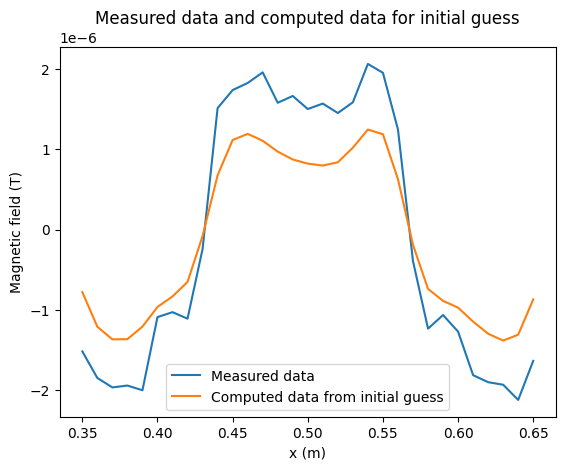

In [6]:
def Tikhonov_Regularization(G, d, epsilon):
    """This function finds an approximate solution m to a linear inverse problem d=Gm."""
    m_estimate = np.linalg.inv(np.matmul(G.T, G) + epsilon**2 * np.identity(len(x_m))) @ G.T @ d  # Perform Tikhonov Regularization
    return m_estimate

m_initial = Tikhonov_Regularization(G_matrix, d_vector, epsilon=0.00005)  # compute initial guess

print(f"norm(d_obs - G m_est)^2 = {np.linalg.norm(d_vector-G_matrix@m_initial)**2} T")
print(f"N sigma^2 = {N_bands*sigma_data**2} T")

# plot measured data and generated data from approximate solution
plt.figure();
plt.plot(x_d, d_vector, label="Measured data");
plt.plot(x_d, G_matrix@m_initial, label="Computed data from initial guess");
plt.xlabel("x (m)");
plt.ylabel("Magnetic field (T)");
plt.title("Measured data and computed data for initial guess");
plt.legend();

Now I am ready to implement the Metropolis algorithm. The Metropolis algorithm works as follows:

Given random rules that define a random walk that samples the probability distribution $\rho(m)$, the null-information probability distribution $\mu(m)$ and another probability distribution over the same space $L(m)$, the Metropolis algortihm samples the probability distribution

$$\sigma(m) = \frac{\rho(m) L(m)}{\mu(m)}.$$

The way this works is that in each iteration of the algorithm, a step from $m_j$ to $m_i$ is proposed by the random walk that samples $\rho(m)$. If $\frac{L(x_i)}{\mu(x_i)} \geq \frac{L(x_j)}{\mu(x_j)}$, the step is accepted. And if $\frac{L(x_i)}{\mu(x_i)} < \frac{L(x_j)}{\mu(x_j)}$, the step is accepted with probability $P = \frac{L(x_i)/\mu(x_i)}{L(x_j)/\mu(x_j)}$. However, since the homogenous probability distribution is just a constant in our case, $\mu(m)$ can be ignored in all of these formulas.

The Metropolis acceptance rule can be implemented as

$$P_{accept} = \min(1, \frac{L_i}{L_j})$$

or equivilantly

$$P_{accept} = \min(1, \exp(S_j - S_i)).$$

I choose the latter implementation since this is more numerically stable. The reason for this is that the exponential function in the Likelihood causes the Likelihood to yield extremely small values and thus risking underflow. Therefore using the mitfit instead, which is minus the logarithm of the Likelihood, means that decently sized numbers are compared instead.

However, I need to be careful when the Likelihood is zero because in this case, the misfit is undefined. However, as  $L \rightarrow 0$, $\log(L) \rightarrow - \infty$. And therefore, $S \rightarrow \infty$ as $L \rightarrow 0$. Hence, $P_{accept} \rightarrow 0$ in this case. I implement this explicitly in my code to avoid getting a warning when $L=0$. 

In [7]:
def m_sigma(m_ini, N_samples=N_samples):
    """This function generates N_samples samples of the a posteriori probability distribution according to the Metropolis rule."""

    m0 = np.copy(m_ini)  # initialize the current model
    m_accepted = np.zeros((N_samples, N_bands))  # initialize array for accepted models
    L_accepted = np.zeros(N_samples)  # initialize array for Likelihood of accepted models

    for i in range(N_samples):  # generate N_samples models

        while True:
            m_test = sample_prior(m0)  # sample a model from the prior
            if L(m_test) == 0:
                p_accept = 0  # if the Likelihood of the proposed model is 0, the acceptance probability is zero
            else:
                p_accept = min(1, np.exp(S(m0)-S(m_test)))  # compute acceptance probability according to the Metropolis rule
                
            if np.random.uniform() < p_accept:  # break loop if new model is accepted
                break
        
        m_accepted[i, :] = m_test  # save the accepted model
        L_accepted[i] = L(m_test)  # save the Likelihood of the accepted model
        m0 = m_test  # set the new accepted model as the current model
    
    return m_accepted, L_accepted

In [8]:
m_sampled, L_sampled = m_sigma(m_initial)  # generate a large number of models distributed according to the a posteriori distribution

I recall that a random walk has a "burn-in" period before converging to generating models that are distributed well according to the a posteriori distribution. Therefore, I start by determining this "burn-in" period so that I can filter these "bad" initial models away. To determine the "burn-in" period, I plot the log(Likelihood) of the accepted models as a function of iteration. The "burn-in" period is over when the log(Likelihood) becomes flat on average.

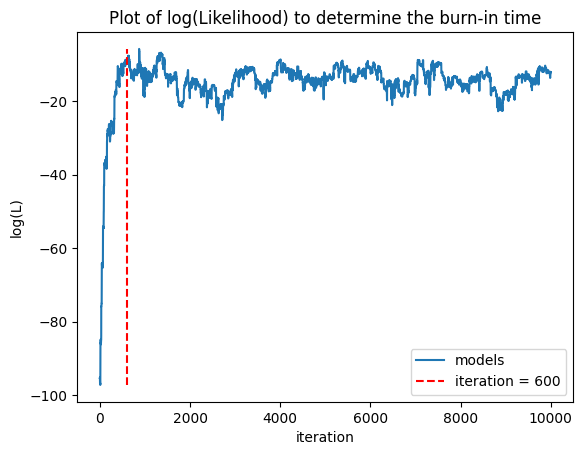

In [9]:
# plot the log(Likelihood) as a function of iteration
plt.plot(np.arange(N_samples), np.log(L_sampled), label="models")
plt.plot((600, 600), (np.min(np.log(L_sampled)), np.max(np.log(L_sampled))), "r--", label="iteration = 600")  # plot a vertical line at i=600 (end of burn-in time)
plt.title("Plot of log(Likelihood) to determine the burn-in time")
plt.xlabel("iteration")
plt.ylabel("log(L)")
plt.legend()

From this I see that the log(Likelihood) has converged after approximately 600 iterations (see red striped line). Therefore I omit the first 600 models in the following in order to filter out the "bad" initial models.

Now I visualize the computed data of 10 models generated after the "burn-in" period to see if they resemble the measured data.

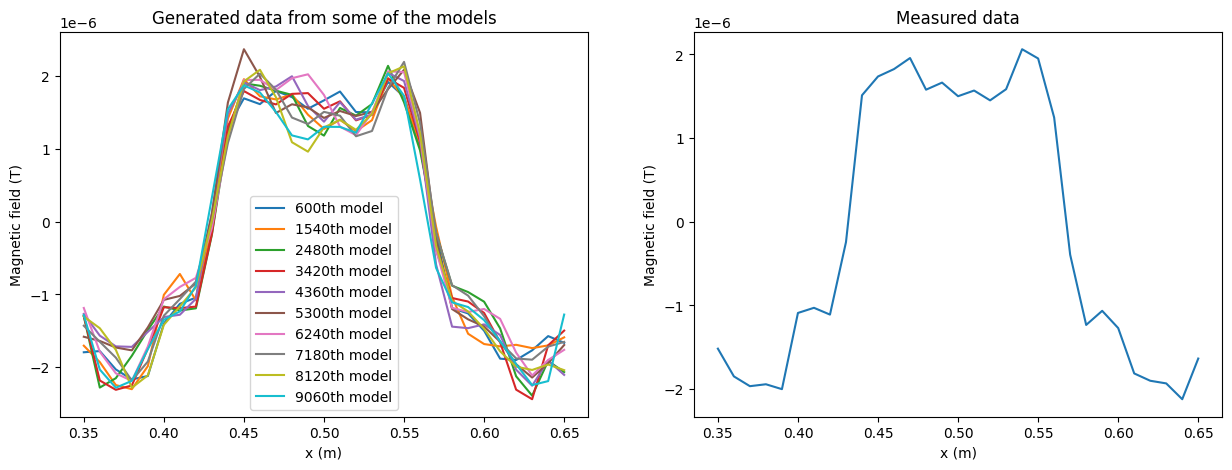

In [10]:
# plot 10 of the generated models (after the burn-in time)
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

model_i = np.arange(600, N_samples, 940)
for i in model_i:
    ax[0].plot(x_d, G_matrix@m_sampled[i], label=f"{i}th model")

ax[1].plot(x_d, d_vector)  # plot the measured data

ax[0].set_xlabel("x (m)")
ax[1].set_xlabel("x (m)")

ax[0].set_ylabel("Magnetic field (T)")
ax[1].set_ylabel("Magnetic field (T)")

ax[0].set_title("Generated data from some of the models")
ax[1].set_title("Measured data")

ax[0].legend()


As expected, the generated data from the different models is very similar and hence the algorithm seems to have converged. And the generated data follows the same trend as the measured data quite well.

Now I plot the last generated model (magnetization as a function of position on the magnetized plate). I expect to see a structure where the bands form a number of stripes of varying length consisting of consecutive bands with the same magnetization. In order to better vizualise the stripes, I plot a grey vertical line at each stripe boundary.

Text(0.5, 0, 'x (m)')

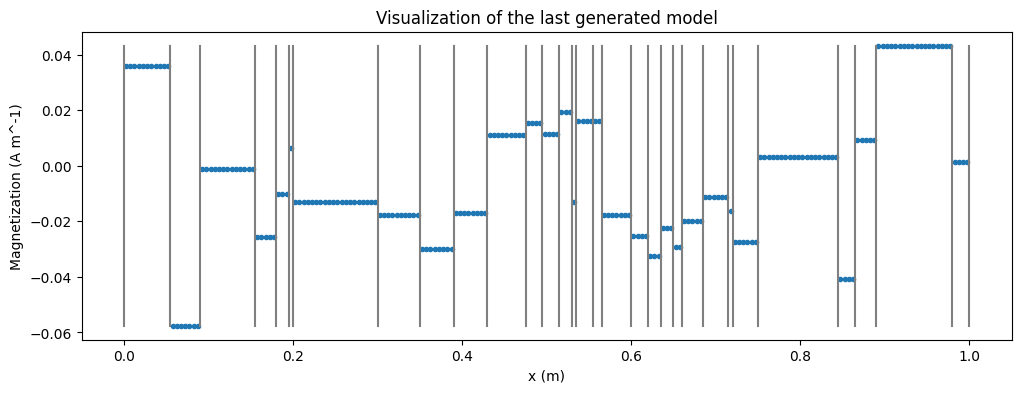

In [11]:
plt.figure(figsize=(12,4))
plt.plot(x_m, m_sampled[-1], ".")  # plot the magnetization of each band

# plot vertical lines at the stripe boundaries
for i in range(len(m_sampled[-1])-1):
    if m_sampled[-1][i] != m_sampled[-1][i+1]:
        plt.plot((x_m[i]+dx/2, x_m[i]+dx/2), (np.min(m_sampled[-1]), np.max(m_sampled[-1])), color="grey", linestyle="-")

# plot vertical lines at the beginning and end of the plate
plt.plot((np.min(x_m)-dx/2, np.min(x_m)-dx/2), (np.min(m_sampled[-1]), np.max(m_sampled[-1])), color="grey", linestyle="-")
plt.plot((np.max(x_m)+dx/2, np.max(x_m)+dx/2), (np.min(m_sampled[-1]), np.max(m_sampled[-1])), color="grey", linestyle="-")

plt.title("Visualization of the last generated model")
plt.ylabel("Magnetization (A m^-1)")
plt.xlabel("x (m)")

I also check that the widths of the stripes of the last generated model approximately follow an exponential distribution.

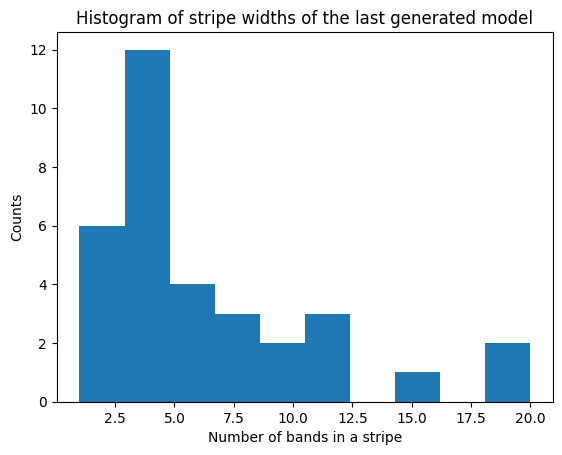

In [12]:
boundaries = np.where(m_sampled[-(i+2)][:-1] != m_sampled[-(i+2)][1:])[0] + 1  # locate the boundaries of each stripe
stripes = np.split(m_sampled[-(i+2)], boundaries)

stripe_width = []
for j in range(len(boundaries)+1):
    stripe_width.append(len(stripes[j]))

plt.hist(stripe_width, bins=10);
plt.title("Histogram of stripe widths of the last generated model");
plt.ylabel("Counts");
plt.xlabel("Number of bands in a stripe");

Given the fact that there are relatively few stripes in a model, I did not expect this to follow a perfect exponential. But the general shape of the histogram resembles an exponential as expected.

### Problem 5

Now I want to determine the uncertainties on the model parameters. That is, I want to measure the dispersion of the parameters of the generated models. A way to measure the dispersion of the model parameters is by computing the standard deviation of a given model parameter over all of the generated models (after the "burn-in" period). But first, I plot histograms of a few randomly selected model parameters to see that they follow an approximately Gaussian distribution.

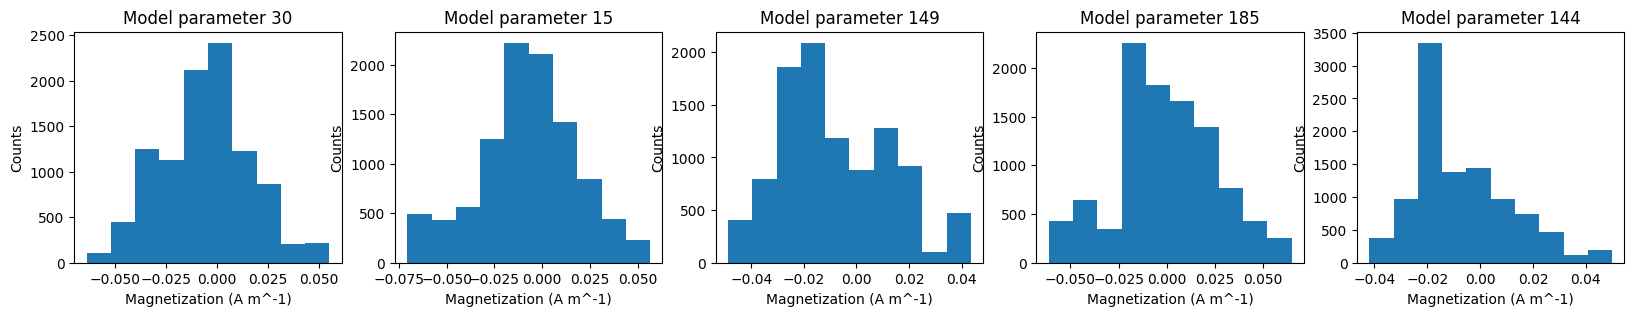

In [13]:
random_models = np.random.randint(0, 200, size=5)

fig1, ax1 = plt.subplots(ncols=5, figsize=(20,3))

for i, model in enumerate(random_models):
    ax1[i].hist(m_sampled[:,model], bins=10);
    ax1[i].set_title(f"Model parameter {model}")
    ax1[i].set_xlabel("Magnetization (A m^-1)")
    ax1[i].set_ylabel("Counts")
    ax1[i].plot()

As expected, these distributions are not perfect Gaussians. But they do seem to generally follow the trend of having a peak in the center and gradually falling off to the sides like a Gaussian. Therefore, the standard deviation is a decent measure of the dispersion of the model parameters.

I explicitly print the maximum standard deviation and the minimum standard deviation. And I plot the standard deviation as a function of band.

The maximum standard deviation is 0.0338 A m^-1.
The minimum standard deviation is 0.0023 A m^-1.


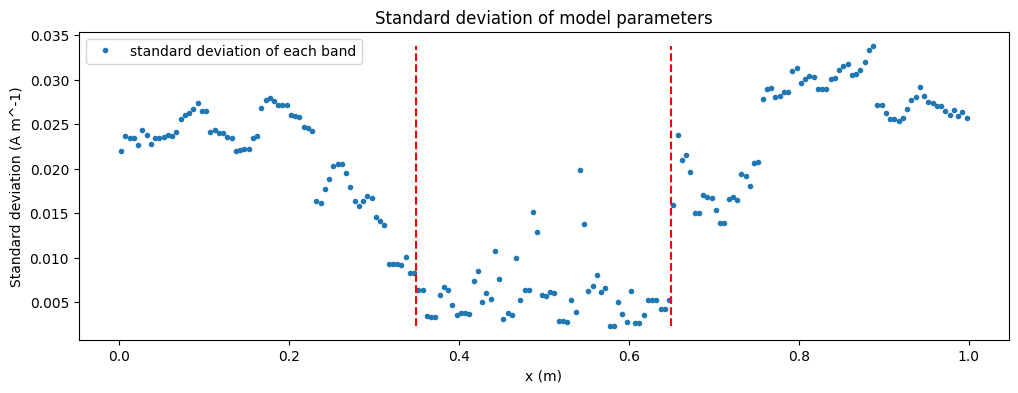

In [14]:
sigma_m = m_sampled[600:].std(axis=0)  # compute standard deviation of model parameters

print(f"The maximum standard deviation is {np.max(sigma_m):.4f} A m^-1.")
print(f"The minimum standard deviation is {np.min(sigma_m):.4f} A m^-1.")

#plot standard deviation as a function of band
plt.figure(figsize=(12,4));
plt.plot(x_m, sigma_m, ".", label="standard deviation of each band");
plt.plot((np.min(x_d), np.min(x_d)), (np.min(sigma_m), np.max(sigma_m)), linestyle="--", color="red")
plt.plot((np.max(x_d), np.max(x_d)), (np.min(sigma_m), np.max(sigma_m)), linestyle="--", color="red")
plt.title("Standard deviation of model parameters")
plt.ylabel("Standard deviation (A m^-1)")
plt.xlabel("x (m)")
plt.legend();

I see that the dispersion of each model parameter lies between $0.0023$ $A m^{-1}$ and $0.034$ $A m^{-1}$. Furthermore, I notice that the dispersion is generally smaller between $x = 0.35$ m and $x = 0.65$ m (marked by vertical striped lines). This is expected since this is the range over which I have measured data of the magnetic field. It makes sense that the Metropolis algorithm can estimate the magnetization of the bands more precisely over the range for which I have data than outside it.